In [20]:

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates

In [21]:
'''
def gdas2radiosonde(src_file,dst_file,
        col_names = ['PRES','HGHT','TEMP','UWND',
                     'VWND','WWND','RELH','TPOT','WDIR','WSPD']):
	"""
	Helper function that converts a gdas file from TROPOS server, to a simple txt.
	The resulting file is without any prior info, and resembles the table format
	of a radiosonde file (see class: RadiosondeProfile)
	:param src_file: source file name
	:param dst_file: destination file name
	:param col_names: column names of the final table
	"""
	import pandas as pd
	from pandas.api.types import is_numeric_dtype

	data_src = pd.read_fwf(src_file,skiprows=[0,1,2,3,4,5,6,8],
	                       delimiter="\s+",skipinitialspace=True).dropna()
	# converting any kind of blanc spaces to zeros
	for col in data_src.columns:
		if not is_numeric_dtype(data_src[col]):
			data_src[col]= pd.core.strings.str_strip(data_src[col])
			data_src[col]= data_src[col].replace('','0').astype('float64')
	data_src.columns = col_names
	data_src.to_csv(dst_file,index=False,sep='\t',na_rep='\t')
	# TODO: add warning if failed
def extract_date_time(path,format_filename,format_times):
	# Extracting datetime from file name using a formatter string.
	#
	# Usage:
	# create a formatter string: format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
	# Call the function:        f time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
	# Output:
	#       time_stamps - A list of datetime objects
	import re
	filename = os.path.basename(path)
	#print(filename)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	# print(matchObj)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps
def calc_sigma_profile_df(row,lambda_um = 532.0,indx_n= 'sigma'):
	"""
	Returns pd series of extinction profile [1/m] from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'sigma'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of extinction profile [1/m]
	"""
	return pd.Series([rayleigh_scattering.alpha_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[indx_n])
def calc_beta_profile_df(row,lambda_um = 532.0,ind_n= 'beta'):
	"""
	Returns pd series of backscatter profile from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'beta'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of backscatter profile [1/sr*m]
	"""
	return pd.Series([rayleigh_scattering.beta_pi_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[ind_n])
'''

'\ndef gdas2radiosonde(src_file,dst_file,\n        col_names = [\'PRES\',\'HGHT\',\'TEMP\',\'UWND\',\n                     \'VWND\',\'WWND\',\'RELH\',\'TPOT\',\'WDIR\',\'WSPD\']):\n\t"""\n\tHelper function that converts a gdas file from TROPOS server, to a simple txt.\n\tThe resulting file is without any prior info, and resembles the table format\n\tof a radiosonde file (see class: RadiosondeProfile)\n\t:param src_file: source file name\n\t:param dst_file: destination file name\n\t:param col_names: column names of the final table\n\t"""\n\timport pandas as pd\n\tfrom pandas.api.types import is_numeric_dtype\n\n\tdata_src = pd.read_fwf(src_file,skiprows=[0,1,2,3,4,5,6,8],\n\t                       delimiter="\\s+",skipinitialspace=True).dropna()\n\t# converting any kind of blanc spaces to zeros\n\tfor col in data_src.columns:\n\t\tif not is_numeric_dtype(data_src[col]):\n\t\t\tdata_src[col]= pd.core.strings.str_strip(data_src[col])\n\t\t\tdata_src[col]= data_src[col].replace(\'\',\'0\')

In [22]:
'''set day'''

day_date = datetime(2017,9,1)

'''Set paths to parents folder '''
lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'


In [23]:
lidar_day_folder = os.path.join(lidar_parent_folder,day_date.strftime("%Y\%m\%d"))
os.listdir(lidar_day_folder)
bsc_pattern = os.path.join(lidar_day_folder,"*_att_bsc.nc")
bsc_paths = sorted(glob.glob(bsc_pattern))
#bsc_paths
profile_pattern = os.path.join(lidar_day_folder,"*[0-9]_profiles.nc")
profile_paths = sorted(glob.glob(profile_pattern))
#profile_paths


In [24]:
haifa_station = gs.station()
#print(haifa_station.__dict__)
src_folder =os.path.join(os.getcwd(),'data examples\gdas')
dst_folder = os.path.join(os.getcwd(),'data examples\gdas_txt')
gdas_dst_paths= prep.gdas_tropos2txt(day_date, haifa_station.location,
                                   haifa_station.lat, haifa_station.lon,
                                   src_folder, dst_folder)

In [25]:
'''set parameters'''
lambda_um = gs.LAMBDA_um().G
location = haifa_station.location
min_height_km = (1E-3)*(haifa_station.altitude + haifa_station.start_bin_height)
top_height_km = (1E-3)*(haifa_station.altitude + haifa_station.end_bin_height)

df_sigma, df_beta = prep.generate_daily_molecular_profile(
	gdas_dst_paths,lambda_um,haifa_station.location, haifa_station.lat,
	haifa_station.lon,min_height_km , top_height_km,haifa_station.n_bins)

df_sigma

,2017-09-01 00:00:00,2017-09-01 03:00:00,2017-09-01 06:00:00,2017-09-01 09:00:00,2017-09-01 12:00:00,2017-09-01 15:00:00,2017-09-01 18:00:00,2017-09-01 21:00:00,2017-09-02 00:00:00
0.307750,1.222132e-05,1.221421e-05,1.219077e-05,1.216900e-05,1.215608e-05,1.214148e-05,1.214498e-05,1.215416e-05,1.215908e-05
0.315221,1.221402e-05,1.220682e-05,1.218334e-05,1.216172e-05,1.214879e-05,1.213427e-05,1.213771e-05,1.214688e-05,1.215153e-05
0.322693,1.220671e-05,1.219947e-05,1.217588e-05,1.215442e-05,1.214149e-05,1.212705e-05,1.213043e-05,1.213961e-05,1.214398e-05
0.330164,1.219940e-05,1.219212e-05,1.216842e-05,1.214713e-05,1.213418e-05,1.211983e-05,1.212315e-05,1.213233e-05,1.213643e-05
0.337636,1.219209e-05,1.218476e-05,1.216096e-05,1.213983e-05,1.212688e-05,1.211260e-05,1.211587e-05,1.212505e-05,1.212888e-05
...,...,...,...,...,...,...,...,...,...
22.684774,7.140280e-07,7.148756e-07,7.163237e-07,7.162552e-07,7.142508e-07,7.143293e-07,7.141014e-07,7.141460e-07,7.125847e-07
22.692246,7.132981e-07,7.141467e-07,7.155945e-07,7.155249e-07,7.135222e-07,7.136011e-07,7.133720e-07,7.134145e-07,7.118500e-07
22.699717,7.125684e-07,7.134180e-07,7.148654e-07,7.147947e-07,7.127937e-07,7.128729e-07,7.126427e-07,7.126830e-07,7.111154e-07
22.707189,7.118387e-07,7.126894e-07,7.141364e-07,7.140646e-07,7.120652e-07,7.121449e-07,7.119135e-07,7.119517e-07,7.103810e-07


<Figure size 432x288 with 0 Axes>

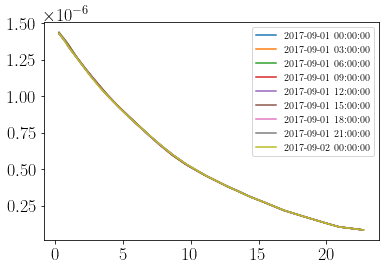

In [26]:
plt.figure()
df_beta.plot()
plt.show()

In [32]:
def generate_att_bsc_mol(lambda_um, station, time_res='30S'):
	"""	 """

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''
	min_height_km = (station.altitude + station.start_bin_height) * 1E-3
	top_height_km = (station.altitude + station.end_bin_height) * 1E-3

	df_sigma, df_beta = prep.generate_daily_molecular_profile(
		gdas_dst_paths,lambda_um,station.location, station.lat,
		station.lon,min_height_km , top_height_km,station.n_bins)

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	heights = np.linspace(station.altitude + station.start_bin_height,
                      station.altitude + station.end_bin_height,
                      station.n_bins)
	interp_sigma_df.index = heights
	interp_sigma_df.columns.freq = None
	interp_beta_df.index = heights
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)


	import xarray as xr
	mol_xr= xr.DataArray(data=[interp_beta_df,interp_sigma_df,att_bsc_mol_df],
                     coords=[['beta','sigma','att_bsc_mol'],interp_beta_df.index,interp_beta_df.columns],
                     dims = ['profiles','height','time'],
                     name='molecular')#,interp_beta_df.index,interp_beta_df.columns )



	return att_bsc_mol_df,mol_xr

In [33]:
print('df_mol')
lambda_um = gs.LAMBDA_um().G
location = haifa_station.location
mol_df,mol_xr = generate_att_bsc_mol(lambda_um, haifa_station, time_res='30S')
mol_xr

# TODO: make sure mol_df units has consistant units 1/m vs 1/km
# TODO: define attributes of mol_xr
# TODO: create xarray to a daily molecular profile for three channels
# TODO: convert from xarray to pytorch

df_mol


AttributeError: module 'preprocessing' has no attribute 'cal_e_tau_df'

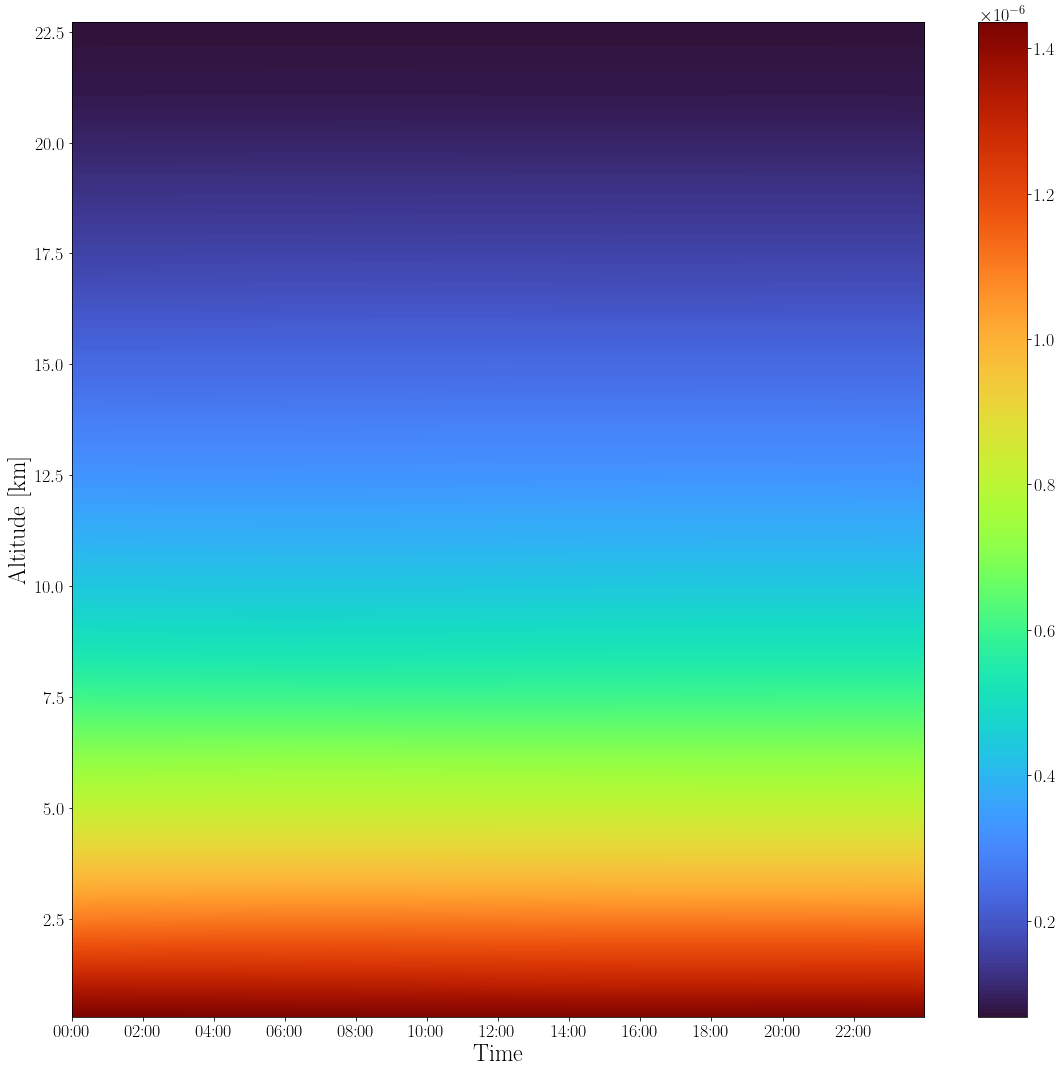

In [29]:
cur_df= mol_df
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize =24)
ax.set_xlabel('Time',fontsize =24)
plt.rc('xtick',labelsize =18)
plt.rc('ytick',labelsize=18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [30]:
''' read radiosonde at 00:00 and 12:00 and 00:00 (of the day after)'''
## radiosonde download and analysis from cameranetwork

''' read gdas data for 00:00, 03:00, 06:00, 09:00 ,12:00, 15:00 , 18:00 ,21:00, 24:00'''
## use: https://github.com/martin-rdz/ARLreader


## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.
''' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '''

' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '

In [31]:
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}